# Pfeffel Processing for Boris Bikes

In [1]:
import datetime

import h3 # uber geo package
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib

from tqdm.auto import tqdm

In [2]:
sns.set_theme()
tqdm.pandas()

TODO: this needs doesn't persist in initial notebook run and has to be run again separately and charts redrawn :( - fix

In [45]:
matplotlib.rcParams['figure.figsize'] = (20, 10)

# load

load reference data for bike station locations

In [4]:
# TODO update
RAW = "/Users/jbishop/Downloads/cleaned_data_20220612_1302.pickle"

LOCATION_REF = "./data/stations_loc.json"

In [5]:
station_locations_df = pd.read_json(LOCATION_REF).T

main data, load with dask

In [6]:
# load raw data
df = pd.read_pickle(RAW)

about 100M rows

In [7]:
# num rows
len(df)

99448614

some cleaning of bad dates

In [8]:
EARLIEST_DATE = datetime.datetime(2010, 1, 1)

In [9]:
%%time
# filter out of range dates
df = df[df["start_date"] > EARLIEST_DATE]
# allow NA for end dates
df = df[(df["end_date"] > EARLIEST_DATE) | df["end_date"].isna()]

# also drop entries where start date before end date
df = df[df["start_date"] < df["end_date"]]

# recalc duration
df["duration"] = df["end_date"]  - df["start_date"] 

CPU times: user 42.8 s, sys: 12.4 s, total: 55.1 s
Wall time: 55.2 s


we've lost a few!

In [10]:
len(df)

98907750

# Basic stats

In [11]:
%%time
# how many bikes
df["bike_id"].nunique()

CPU times: user 6.94 s, sys: 880 ms, total: 7.82 s
Wall time: 7.8 s


21149

In [12]:
bike_groups = df.groupby("bike_id")

In [13]:
%%time
# bike with the most trips
group_counts = bike_groups.count()["filename"] # pick abritrary column (without nulls) to get counts
b_id = group_counts.idxmax()
n_trips = group_counts.loc[b_id]

print(f"""
bike with most trips: {b_id}
did {n_trips} trips
""")


bike with most trips: 8875
did 10197 trips

CPU times: user 36.3 s, sys: 507 ms, total: 36.8 s
Wall time: 36.7 s


In [14]:
%%time
# bike with the longest trips
group_sums = bike_groups["duration"].sum()
b_id = group_sums.idxmax()
d_sum = group_sums.loc[b_id]


print(f"""
bike with longest sum duration of trips: {b_id}
total of {d_sum} seconds
""")


bike with longest sum duration of trips: 2143
total of 234 days 19:13:00 seconds

CPU times: user 907 ms, sys: 171 ms, total: 1.08 s
Wall time: 1.08 s


how long are trips? (excluding outliers)

<AxesSubplot:>

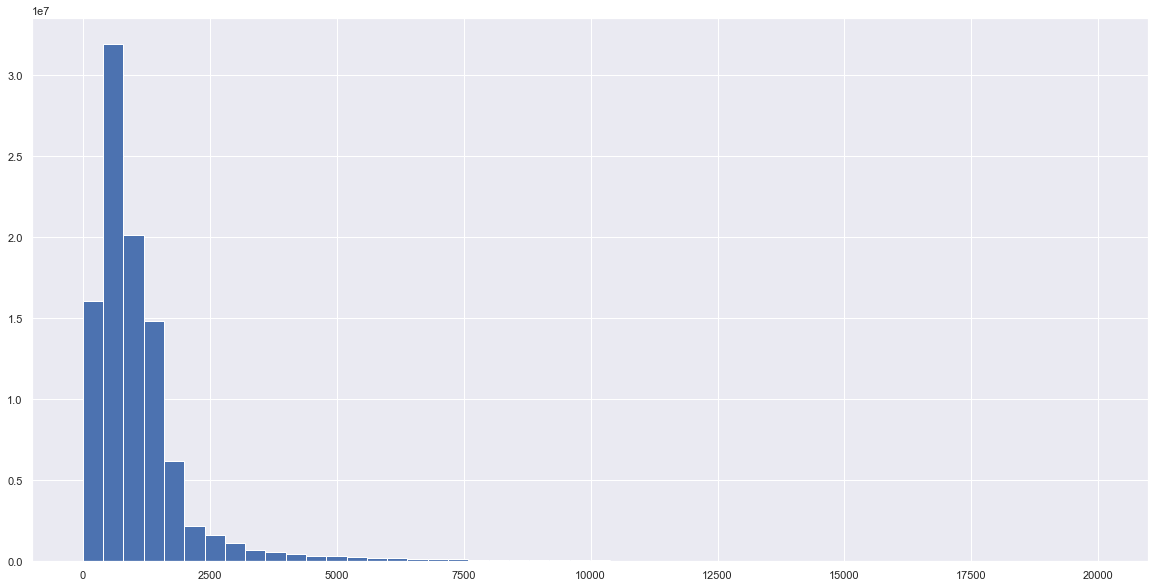

In [46]:
df[df["duration"].dt.seconds < 20000]["duration"].dt.seconds.hist(bins=50)

## Long-lived bikes

In [16]:
%%time
trips_per_bike = bike_groups["filename"].count()

CPU times: user 3.44 s, sys: 22.2 ms, total: 3.46 s
Wall time: 3.46 s


In [17]:
%%time
# relies on time ordering of df via rental_id
bike_start = bike_groups["start_date"].first()

CPU times: user 372 ms, sys: 1.42 ms, total: 373 ms
Wall time: 371 ms


In [18]:
%%time
# relies on time ordering of df via rental_id
bike_end = bike_groups["end_date"].last()

CPU times: user 499 ms, sys: 1.3 ms, total: 501 ms
Wall time: 499 ms


In [19]:
%%time 
bike_lifetime = bike_end - bike_start

CPU times: user 1.6 ms, sys: 1.06 ms, total: 2.66 ms
Wall time: 1.79 ms


how long is the lifetime of a bike? (in days)

<AxesSubplot:>

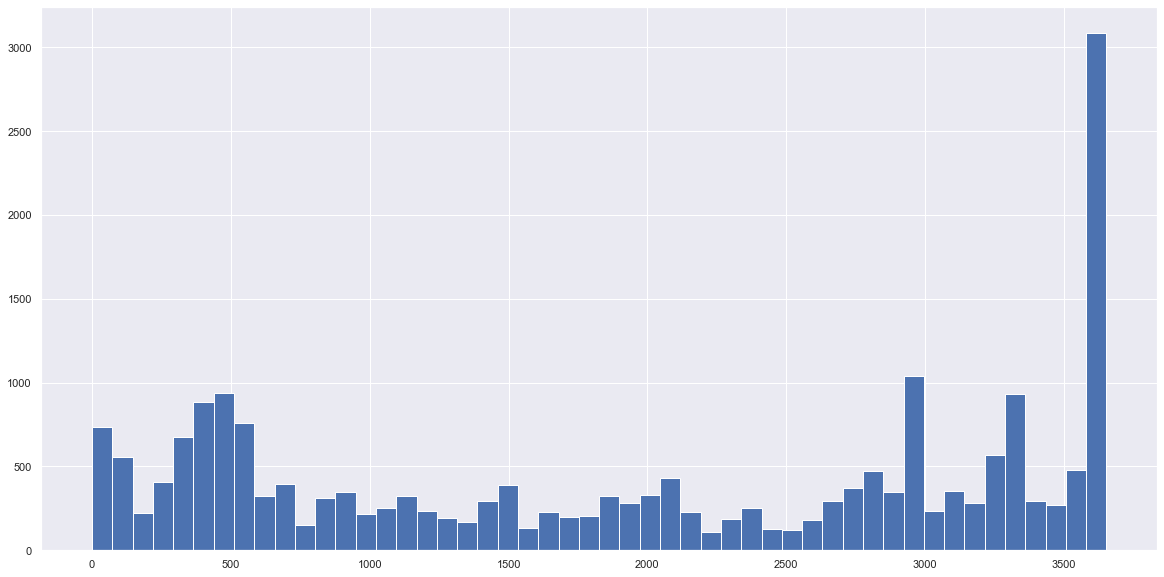

In [47]:
bike_lifetime.dt.days.hist(bins=50)

In [21]:
%%time
duration_sums = bike_groups["duration"].sum()

CPU times: user 1 s, sys: 175 ms, total: 1.18 s
Wall time: 1.18 s


In [22]:
%%time
bike_utilisation = duration_sums / bike_lifetime

CPU times: user 561 µs, sys: 255 µs, total: 816 µs
Wall time: 594 µs


what is the average utilisation of a bike? (total ride duration / lifetime)

In [23]:
bike_utilisation.mean()

0.041590354670607635

<AxesSubplot:>

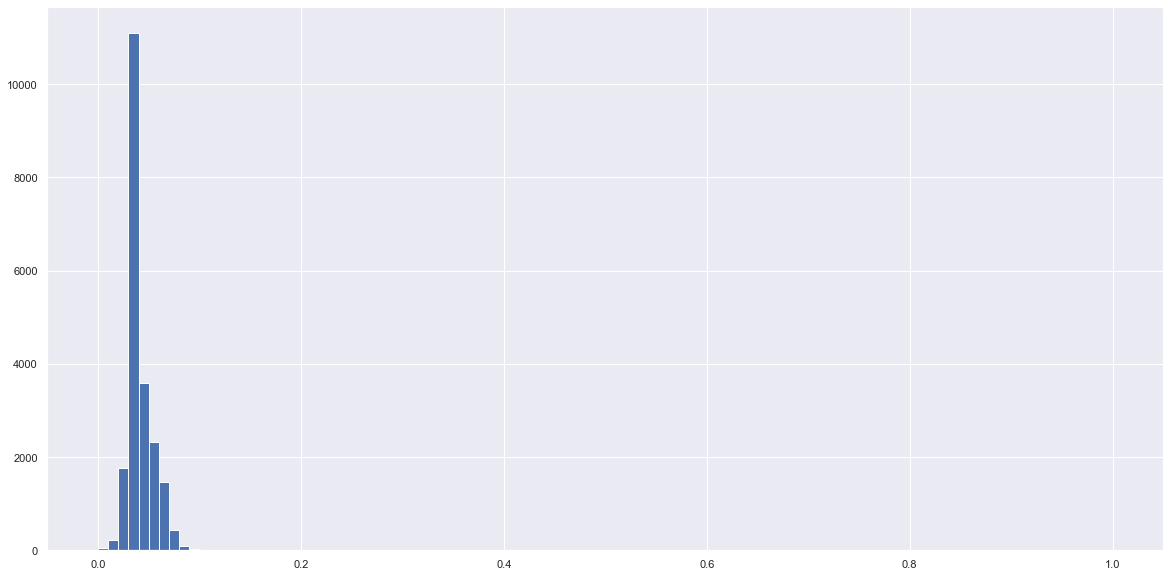

In [48]:
bike_utilisation.hist(bins=100)

### per month

- how many bikes are "alive" by month?

- how many stations are "alive" by month?

- what is bike utilisation by month?

In [25]:
# don't want to incude first and last months as may be incompelte, use in filter later
incomplete_months = df["start_date"].iloc[[0, -1]].dt.to_period("M")


# create a complete monthly index that covers ALL months in period 
complete_monthly_index = pd.date_range(start=df["start_date"].iloc[0], end=df["end_date"].iloc[-1], freq="M").to_period("M")
# remove incomplete months
complete_monthly_index = complete_monthly_index.delete(complete_monthly_index.isin(incomplete_months))

In [26]:
# TODO should stations count as allive for next month rather than current?
def calc_alive_per_month(starts: pd.Series, ends: pd.Series, incomplete_months: pd.Series, complete_monthly_index: pd.PeriodIndex):
    starts_per_month = starts.dt.to_period("M").value_counts()
    ends_per_month = ends.dt.to_period("M").value_counts()

    counts_df = complete_monthly_index.to_frame(name="foo").join(starts_per_month).join(ends_per_month).sort_index().fillna(0)
    # ending items should only be counted at the start of next month, so shift
    counts_df["end_date"] = counts_df["end_date"].shift(fill_value=0)

    alive_per_month = counts_df["start_date"].cumsum() - counts_df["end_date"].cumsum()
    
    return alive_per_month[~alive_per_month.index.isin(incomplete_months)]

In [27]:
%%time

alive_bikes_per_month = calc_alive_per_month(starts=bike_start, ends=bike_end, incomplete_months=incomplete_months, complete_monthly_index=complete_monthly_index)

CPU times: user 8.52 ms, sys: 1.93 ms, total: 10.5 ms
Wall time: 12.7 ms


In [28]:
%%time
duration_sums_per_month = df[["duration"]].groupby(df["start_date"].dt.to_period("M"))["duration"].sum()

duration_sums_per_month = duration_sums_per_month.to_frame()
duration_sums_per_month["max_possible_duration"] = duration_sums_per_month.index.map(lambda x: x.end_time - x.start_time)

utilisation_per_month = duration_sums_per_month["duration"] / duration_sums_per_month["max_possible_duration"] / alive_bikes_per_month

# remove incomplelte months
utilisation_per_month = utilisation_per_month[~utilisation_per_month.index.isin(incomplete_months)]

CPU times: user 4.72 s, sys: 1.06 s, total: 5.78 s
Wall time: 5.78 s


In [29]:
%%time

station_groups = df.groupby("start_station_id")

# relies on time ordering of df via rental_id
station_start = station_groups["start_date"].first()
station_end = station_groups["end_date"].last()

CPU times: user 5.58 s, sys: 325 ms, total: 5.91 s
Wall time: 5.89 s


In [30]:
alive_stations_per_month = calc_alive_per_month(starts=station_start, ends=station_end,
                                                incomplete_months=incomplete_months, complete_monthly_index=complete_monthly_index)

In [31]:
# forward fill gaps
stats_df = complete_monthly_index.to_frame(name="date")\
    .join(alive_bikes_per_month.rename("alive_bikes"))\
    .join(alive_stations_per_month.rename("alive_stations"))\
    .join(utilisation_per_month.rename("utilisation"))\
    .fillna(method="ffill") 

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

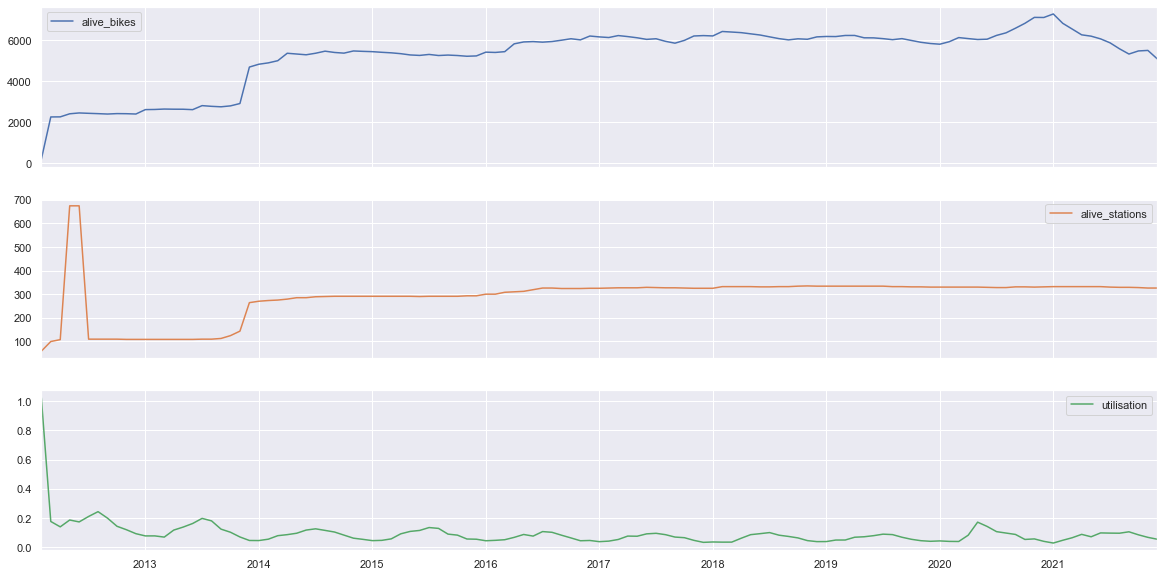

In [49]:
stats_df.plot(subplots=True)

<AxesSubplot:>

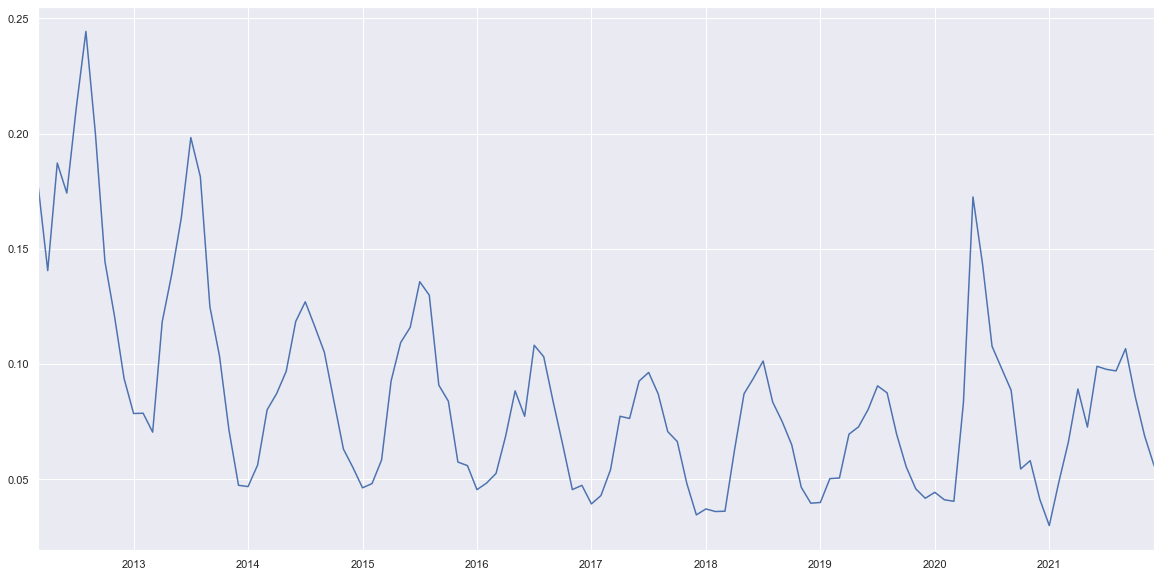

In [50]:
stats_df["utilisation"][1:].plot()

whats happening to the number of active stations in 2012?

In [34]:
stats_df_2012 = stats_df[(stats_df.index.to_timestamp() >= datetime.datetime(year=2012, month=1, day=1)) &
        (stats_df.index.to_timestamp() < datetime.datetime(year=2013, month=1, day=1))]


# increase in April and Decrease in Jul

may_2012_new_stations = station_start[(station_start >= datetime.datetime(year=2012, month=5, day=1)) &
             (station_start < datetime.datetime(year=2012, month=6, day=1))]

# note these will actually be last used in prev month i.e. june
jul_2012_removed_stations = station_end[(station_end >= datetime.datetime(year=2012, month=6, day=1)) &
             (station_end < datetime.datetime(year=2012, month=7, day=1))]

len(may_2012_new_stations), len(jul_2012_removed_stations)

(568, 566)

## Station Areas

In [35]:
%%time
all_stations = pd.concat([
    df[["start_station_id", "start_station_name"]].rename(columns={"start_station_id": "id", "start_station_name": "name"}),
    df[["end_station_id", "end_station_name"]].rename(columns={"end_station_id": "id", "end_station_name": "name"})
]).convert_dtypes().set_index(keys="id").drop_duplicates().dropna()

# filter to str names only
all_stations = all_stations[all_stations["name"].map(lambda x: isinstance(x, str))]

CPU times: user 54.6 s, sys: 10.4 s, total: 1min 5s
Wall time: 1min 5s


have a look at station name pieces, is the part after the comma an "area"?

In [36]:
station_name_pieces = all_stations["name"].progress_map(lambda name: name.split(","))

station_single_pieces = station_name_pieces[station_name_pieces.progress_map(len) <= 1]
station_areas =  station_name_pieces.progress_map(lambda name_pieces: name_pieces[1] if len(name_pieces) > 1 else None).dropna()

  0%|          | 0/1629 [00:00<?, ?it/s]

  0%|          | 0/1629 [00:00<?, ?it/s]

  0%|          | 0/1629 [00:00<?, ?it/s]

what are the items with only one "piece" i.e. no comma

In [37]:
station_single_pieces.head()

id
98.0                  [Hampstead Road: Euston]
216.0    [Old Brompton Road: South Kensington]
23.0                [Red Lion Square: Holborn]
201.0              [Dorset Square: Marylebone]
224.0                  [Whiteley's: Bayswater]
Name: name, dtype: object

In [38]:
station_areas.value_counts()

 Marylebone          28
 Battersea           23
 Westminster         23
 Holborn             21
 Fulham              20
                     ..
 Waterloo             1
Shepherd's Bush       1
 Parson's Green       1
 De Beauvoir Town     1
 Wandswoth Road       1
Name: name, Length: 146, dtype: int64

# chains

A "chain" is a sequence of trips for a given bike, where the start location matches the previous end location.

Run for some subset only. Try long lived bikes

In [39]:
top_ten_lived_bike_ids = bike_lifetime.sort_values()[-10:].index.values

In [40]:
top_ten_bike_subset = df[df["bike_id"].isin(top_ten_lived_bike_ids)].copy()

In [41]:
# NOTE - how to handle workshops?
# what if workshop is start ?
# what if workshop is end ?
def add_chains(bike_id: int, bike_group: pd.DataFrame, df: pd.DataFrame) -> None:
    """ note: adds to dataframe as side effect """

    # note fillna for end station to allow for comparison to NA
    breaks = bike_group[bike_group["start_station_id"] != bike_group.shift()["end_station_id"].fillna(-1)]
    break_indices = breaks.index.values

    chains = list()
    for i, (start, end) in enumerate(zip([None, *break_indices], [*break_indices, None])):
        chain = bike_group.loc[start:end]
        chain_id = f"{bike_id}_{i}"
        chains.append(pd.Series(chain_id, index=chain.index))
    return pd.concat(chains)

In [42]:
chains = list()
for k, g in tqdm(top_ten_bike_subset.groupby("bike_id")):
    g = bike_groups.get_group(k)
    chains.append(add_chains(bike_id=k, bike_group=g, df=df))

  0%|          | 0/10 [00:00<?, ?it/s]

In [43]:
top_ten_bike_subset = top_ten_bike_subset.join(pd.concat(chains).rename("chain_id"))

In [44]:
top_ten_bike_subset.to_pickle("top_ten_bikes.pickle")